## Setup

In [ ]:
!git clone https://github.com/sithu31296/semantic-segmentation
%cd semantic-segmentation
%pip install -e .

Cloning into 'semantic-segmentation'...
remote: Enumerating objects: 792, done.
remote: Counting objects: 100% (789/789), done.
remote: Compressing objects: 100% (312/312), done.
remote: Total 792 (delta 479), reused 749 (delta 470), pack-reused 3
Receiving objects: 100% (792/792), 54.99 MiB | 34.95 MiB/s, done.
Resolving deltas: 100% (479/479), done.
/content/semantic-segmentation
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/semantic-segmentation
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.7/238.7 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 KB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from torchvision import io
from torchvision import transforms as T
from PIL import Image

def show_image(image):
    if image.shape[2] != 3: image = image.permute(1, 2, 0)
    image = Image.fromarray(image.numpy())
    return image

## Show Available Pretrained Models

In [ ]:
from semseg import show_models

show_models()

  No.  Model Names
-----  -------------
    1  SegFormer
    2  Lawin
    3  SFNet
    4  BiSeNetv1
    5  DDRNet
    6  FCHarDNet
    7  BiSeNetv2


## Load a Pretrained Model

Download a pretrained model's weights from the result table (ADE20K, CityScapes, ...) and put it in `checkpoints/pretrained/model_name/`.

In [ ]:
%pip install -U gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
import gdown
from pathlib import Path

ckpt = Path('./checkpoints/pretrained/segformer')
ckpt.mkdir(exist_ok=True, parents=True)

url = 'https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT'
output = './checkpoints/pretrained/segformer/segformer.b3.ade.pth'

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT
To: /content/semantic-segmentation/checkpoints/pretrained/segformer/segformer.b3.ade.pth
100%|██████████| 190M/190M [00:01<00:00, 177MB/s]


'./checkpoints/pretrained/segformer/segformer.b3.ade.pth'

In [ ]:
from semseg.models import *

model = eval('SegFormer')(
    backbone='MiT-B3',
    num_classes=150
)

try:
    model.load_state_dict(torch.load('checkpoints/pretrained/segformer/segformer.b3.ade.pth', map_location='cpu'))
except:
    print("Download a pretrained model's weights from the result table.")
model.eval()

print('Loaded Model')

Loaded Model


## Simple Image Inference

### Load Image

In [ ]:
image_path = './assests/ade/warehouse_container_image.jpg' ## torch.Size([4, 815, 1441])
filename = './assests/ade/warehouse_container_image_out.jpg'

import cv2

image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# show_image(image_rgb)
cv2.imwrite(filename, image_rgb)



True

torch.Size([3, 612, 318])


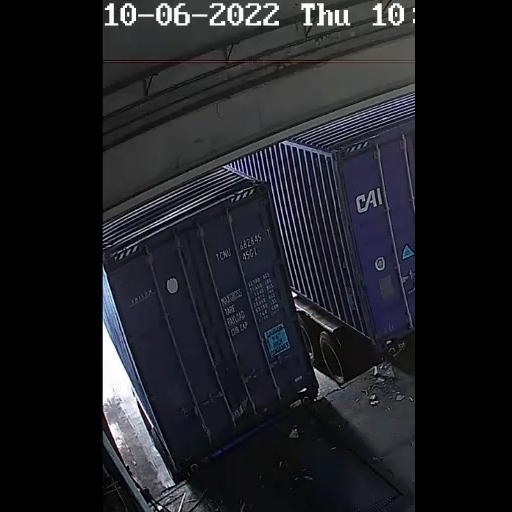

In [ ]:
# image_path = './assests/ade/ADE_val_00000049.jpg' # torch.Size([3, 512, 683])

filename = './assests/ade/warehouse_container_image_out.jpeg'
image_path = filename #'./assests/ade/warehouse_container_image.jpg' ## torch.Size([4, 815, 1441])


image = io.read_image(image_path)
print(image.shape)
# show_image(image)

image2 = T.CenterCrop((512, 512))(image)
show_image(image2)

# test_image = Image.open(image_path).convert('RGB')
# show_image(test_image)


### Preprocess

In [ ]:
# resize
image = T.CenterCrop((512, 512))(image)
# scale to [0.0, 1.0]
image = image.float() / 255
# normalize
image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
# add batch size
image = image.unsqueeze(0)
image.shape

torch.Size([1, 3, 512, 512])

### Model Forward

In [ ]:
with torch.inference_mode():
    seg = model(image)
seg.shape

torch.Size([1, 150, 512, 512])

### Postprocess

In [ ]:
seg = seg.softmax(1).argmax(1).to(int)
seg.unique()

tensor([  0,   2,   3,   5,  14,  40,  41,  43,  54,  83,  96,  98, 105, 141,
        143])

In [ ]:
from semseg.datasets import *

palette = eval('COCOStuff').PALETTE

  No.  Datasets
-----  ---------------
    1  CamVid    2  CityScapes 3  ADE20K    4  MHPv1    5  MHPv2    6  LIP    7  CIHP
    8  CCIHP     9  ATR   10  PASCALContext   11  COCOStuff   12  SUIM   13  SunRGBD
   14  MapillaryVistas   15  HELEN   16  LaPa   17  iBugMask   18  CelebAMaskHQ   19  FaceSynthetics

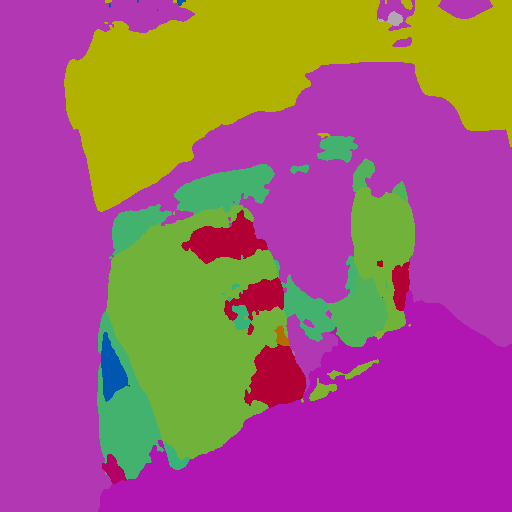

In [ ]:
seg_map = palette[seg].squeeze().to(torch.uint8)
show_image(seg_map)

## Show Available Backbones

In [ ]:
from semseg import show_backbones

show_backbones()

Backbone Names    Variants
----------------  ------------------------------------
ResNet            ['18', '34', '50', '101', '152']
ResNetD           ['18', '50', '101']
MicroNet          ['M1', 'M2', 'M3']
MobileNetV2       ['1.0']
MobileNetV3       ['S', 'L']
MiT               ['B0', 'B1', 'B2', 'B3', 'B4', 'B5']
PVTv2             ['B1', 'B2', 'B3', 'B4', 'B5']
ResT              ['S', 'B', 'L']
PoolFormer        ['S24', 'S36', 'M36']
ConvNeXt          ['T', 'S', 'B']


## Show Available Heads

In [ ]:
from semseg import show_heads

show_heads()

  No.  Heads
-----  -------------
    1  UPerHead
    2  SegFormerHead
    3  SFHead
    4  FPNHead
    5  FaPNHead
    6  FCNHead
    7  CondHead
    8  LawinHead


## Show Available Datasets

In [ ]:
from semseg import show_datasets

show_datasets()

  No.  Datasets
-----  ---------------
    1  CamVid
    2  CityScapes
    3  ADE20K
    4  MHPv1
    5  MHPv2
    6  LIP
    7  CIHP
    8  CCIHP
    9  ATR
   10  PASCALContext
   11  COCOStuff
   12  SUIM
   13  SunRGBD
   14  MapillaryVistas
   15  HELEN
   16  LaPa
   17  iBugMask
   18  CelebAMaskHQ
   19  FaceSynthetics


## Construct a Custom Model

### Choose a Backbone

In [ ]:
from semseg.models.backbones import ResNet

backbone = ResNet('18')

In [ ]:
# init random input batch
x = torch.randn(2, 3, 224, 224)

In [ ]:
# get features from the backbone
features = backbone(x)
for out in features:
    print(out.shape)

torch.Size([2, 64, 56, 56])
torch.Size([2, 128, 28, 28])
torch.Size([2, 256, 14, 14])
torch.Size([2, 512, 7, 7])


### Choose a Head

In [ ]:
from semseg.models.heads import UPerHead

head = UPerHead(backbone.channels, 128, num_classes=10)

In [ ]:
seg = head(features)
seg.shape

torch.Size([2, 10, 56, 56])

In [ ]:
from torch.nn import functional as F
# upsample the output
seg = F.interpolate(seg, size=x.shape[-2:], mode='bilinear', align_corners=False)
seg.shape

torch.Size([2, 10, 224, 224])

Check `semseg/models/custom_cnn.py` and `semseg/models/custom_vit.py` for a complete construction for custom model.